In [1]:
import os
import numpy as np
import h5py
import sys
from scipy import interpolate
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
import math as m
import numpy.ctypeslib as npct
from numpy.ctypeslib import ndpointer
from ctypes import c_int, c_double
import statistics
import seaborn as sns
import cmocean

rc('text', usetex=True)
rc('font', family='serif')

In [2]:
array_1d_float = npct.ndpointer(dtype=np.float64, ndim=1, flags='CONTIGUOUS')

libenergyev = npct.load_library("/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/energy_dens_ev/KHI/lib_new_gamma.so", ".")
libenergyev.energy_ev_khi.restype = None
libenergyev.energy_ev_khi.argtypes = [c_double, c_int,c_double,array_1d_float, array_1d_float]

In [4]:
def readh5files_glob(arx):

    print('DATA FROM FILE:      ',arx)

    with h5py.File(arx, "r") as f:

        Fmean = np.array(f.get('Fmean'))
        sigmaF = np.array(f.get('sigma_F'))
        Rmean = np.array(f.get('Rmean'))
        sigmaR = np.array(f.get('sigma_R'))
        Mmean = np.array(f.get('Mmean'))
        sigmaM = np.array(f.get('sigma_M'))
        rhomean = np.array(f.get('rhomean'))
        time = np.array(f.get('time'))

        M = np.array([Mmean[0,0],Mmean[0,1],Mmean[0,2], Mmean[1,1], Mmean[1,2], Mmean[2,2]])
        errM = np.array([sigmaM[0,0],sigmaM[0,1],sigmaM[0,2],sigmaM[1,1],sigmaM[1,2],sigmaM[2,2]])
        R = np.array([Rmean[0,0],Rmean[0,1],Rmean[0,2], Rmean[1,1], Rmean[1,2], Rmean[2,2]])
        errR = np.array([sigmaR[0,0],sigmaR[0,1],sigmaR[0,2],sigmaR[1,1],sigmaR[1,2],sigmaR[2,2]])
        F = np.array([Fmean[0,1], Fmean[0,2], Fmean[1,2]])
        errF = np.array([sigmaF[0,1],sigmaF[0,2],sigmaF[1,2]])
        f.close()

        print('Time           :',time)

    return [M, R, F, errM, errR, errF, rhomean]

def read_growth(arx):

    with h5py.File(arx, "r") as f:
    # List all groups
        g_khi = np.array(f.get('growth'))

        time = np.array(f.get('time'))

        f.close()

    return g_khi

def readh5files(arx): 
#    print('DATA FROM FILE:      ',arx)

    with h5py.File(arx, "r") as f:
      # List all groups
     #   print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())

        Sf = np.array(f.get('S_f'))
        x = np.array(f.get('x'))
        y = np.array(f.get('y'))
        z = np.array(f.get('z'))
        xf = np.array(f.get('x_f'))
        yf = np.array(f.get('y_f'))
        zf = np.array(f.get('z_f'))
        rho = np.array(f.get('rho_mean'))
        Mxx = np.array(f.get('stress_Mxx'))
        Mxy = np.array(f.get('stress_Mxy'))
        Mxz = np.array(f.get('stress_Mxz'))
        Myy = np.array(f.get('stress_Myy'))
        Myz = np.array(f.get('stress_Myz'))
        Mzz = np.array(f.get('stress_Mzz'))
        Rxx = np.array(f.get('stress_Rxx'))
        Rxy = np.array(f.get('stress_Rxy'))
        Rxz = np.array(f.get('stress_Rxz'))
        Ryy = np.array(f.get('stress_Ryy'))
        Ryz = np.array(f.get('stress_Ryz'))
        Rzz = np.array(f.get('stress_Rzz'))
        Fxx = np.array(f.get('stress_Fxx'))
        Fxy = np.array(f.get('stress_Fxy'))
        Fxz = np.array(f.get('stress_Fxz'))
        Fyx = np.array(f.get('stress_Fyx'))
        Fyy = np.array(f.get('stress_Fyy'))
        Fyz = np.array(f.get('stress_Fyz'))
        Fzx = np.array(f.get('stress_Fzx'))
        Fzy = np.array(f.get('stress_Fzy'))
        Fzz = np.array(f.get('stress_Fzz'))

        time = np.array(f.get('time'))

        f.close()
  
    M = np.array([Mxx,Mxy,Mxz,Myy,Myz,Mzz])
    R = np.array([Rxx,Rxy,Rxz,Ryy,Ryz,Rzz])
    F = np.array([Fyx-Fxy,Fzx-Fxz,Fzy-Fyz])
  
    print('Time           :',time)
  
    return [M, R, F, rho, x, y, z, xf, yf, zf]

#===============================================================================================

def energy_ev(sc,t, factor_c, energy_ini,gamma,rho):

    timestep= 5e-5
    tfinal = t[-1]
    lent = int(round((tfinal)/timestep))+1
    tnew = np.linspace(0,tfinal,lent)

    interpg = interpolate.interp1d(t, gamma, kind = "cubic")
    gamma_khi = interpg(tnew)
    #   interprho = interpolate.interp1d(t,rho,kind = "cubic")
    #   rhoev = interprho(tnew)
    std_fact= factor_c/(rho**(0.5)*sc)


    energy_t = np.zeros(lent)
    energy_t[0] = energy_ini

    libenergyev.energy_ev_khi(std_fact,lent,timestep,gamma_khi, energy_t)

    ratio = int((lent-1)/(len(t)-1))
    energy_model = np.zeros(len(t))

    for i in range(0,len(t)-1):
        energy_model[i] = energy_t[ratio*i]

    energy_model[-1] = energy_t[-1]

    return energy_model

def stresses_r0(res,t):

    path_data = "/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/"+res
    Msim = np.zeros((len(t),6))
    Rsim = np.zeros((len(t),6))
    Fsim = np.zeros((len(t),3))
    errMsq = np.zeros((len(t),6))
    errRsq = np.zeros((len(t),6))
    errFsq = np.zeros((len(t),3))
    rhomean = np.zeros(len(t))
    Mmod_arr = np.zeros((3,len(t), 6))
    Rmod_arr = np.zeros((3,len(t), 6))
    Fmod_arr = np.zeros((3,len(t), 3))

    for tt in range(0, len(t)):

        arx = format(int(10*t[tt]), "04")
        Msim[tt], Rsim[tt], Fsim[tt], errMsq[tt], errRsq[tt], errFsq[tt], rhomean[tt] = readh5files_glob(path_data+'/stresses_sigma_r0_KHI-'+arx+'.h5')

    return Msim, Rsim, Fsim, rhomean

In [ ]:
factor_c = np.linspace(5,15,11)

ss = '24'
bx0 = '3e-4'
leng = 256
res = '/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_256_256_256/CVP--bx'+bx0+'--256--rndom/results/'
tfinal = 40
lent = 401
t = np.linspace(0,tfinal,lent)

Msim = np.zeros((lent,6,15,2,15))
Rsim = np.zeros((lent,6,15,2,15))
Fsim = np.zeros((lent,3,15,2,15))
rhomean = np.zeros((lent,15,2,15))
g_khi= np.zeros((lent,15,2,15))
ekhi = np.zeros((lent,15,2,15))
enKHImod= np.zeros((lent,15,2,15))

inivars = readh5files(res+'stress_tensors/Sf_'+ss+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+ss+'-0000.h5')

xfilter = inivars[7]
yfilter = inivars[8]
zfilter = inivars[9]
    
    
for tt in range(0, lent):        
    arx = format(int(10*t[tt]), "04")
    Msim[tt], Rsim[tt], Fsim[tt], rhomean[tt], x, y, z, xfilter, yfilter, zfilter = readh5files(res+'/stress_tensors/Sf_'+ss+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+ss+'-'+arx+'.h5')
    g_khi[tt] = read_growth(res+'growth_rates/Sf_'+ss+'/growth--'+str(leng)+'--bx'+bx0+'--Sf-'+ss+'-'+arx+'.h5')


energy =0.5*rhomean[:]*(Rsim[:,0]+Rsim[:,3]+Rsim[:,5])
energy_ini = energy[0,:,:,:]
energy_tracerndm = np.mean(energy, axis = (1,2,3))

scale = 15.8*(x[1]-x[0])*int(ss)


fig, ax = plt.subplots(1,4,sharex = 'all', sharey = 'row', figsize = (32,5))
color = sns.color_palette('winter',len(factor_c))
cmap =matplotlib.cm.winter

new_gamma = np.array([0.1,0.14,0.17,0.2])
fig.subplots_adjust(wspace=0.1)

for i in range(0,len(new_gamma)):
    ax[i].tick_params(axis='x',labelsize = 20)
    ax[i].tick_params(axis='y',labelsize = 20)
 
    gamma_khi = g_khi*new_gamma[i]
 
    for k in range(0,len(factor_c)):
        
        energy_trdnm = np.zeros((lent, 15,2,15))
        
        for l in range(0,len(xfilter)):
            for m in range(0,len(yfilter)):
                for n in range(0,len(zfilter)):
 
                    energy_trdnm[:,l,m,n] = energy_ev(scale,t, factor_c[k],energy_ini[l,m,n],gamma_khi[:,l,m,n],rhomean[0,l,m,n])

        energymod = np.mean(energy_trdnm, axis = (1,2,3))
        
        ax[i].plot(t[:], energymod[:],linewidth = .7, linestyle = 'solid', color = color[k])

    energy_trdnm = np.zeros((lent, 15,2,15))
    
    for l in range(0,len(xfilter)):
        for m in range(0,len(yfilter)):
            for n in range(0,len(zfilter)):
 
                energy_trdnm[:,l,m,n] = energy_ev(scale,t, 10.6,energy_ini[l,m,n],gamma_khi[:,l,m,n],rhomean[0,l,m,n])

    energy_opt = np.mean(energy_trdnm, axis = (1,2,3))
    
    ax[i].plot(t[:], energy_opt[:],linewidth = 1.4, linestyle = 'dashed', color = 'r',label=r'$C$=10.6')
    ax[i].plot(t[:], energy_tracerndm[:], linewidth = 1.4, linestyle = 'dashed', color = 'k', label = 'KH-H1')
    ax[i].set_title(r'$A_{\gamma}=$ '+str(new_gamma[i]), fontsize = '24')
    ax[i].set_yscale('log')
    ax[i].set_ylim([1e-4,1])
    ax[i].set_xlim([0,40])
    ax[i].set_xlabel('Time', fontsize = '20')
    ax[i].legend(loc = 'upper right', ncol = 1, frameon = 'True', fontsize = '18')

ax[0].set_ylabel(r'$e_{\rm KH}$', fontsize = '20')
norm = matplotlib.colors.BoundaryNorm(factor_c, cmap.N, extend='both')
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, orientation='vertical')
cb.set_label(r'$C$', size = '20')
cb.ax.tick_params(labelsize='20')

plt.savefig('/home/miquelmiravet/Desktop/figs_khi/energy_ev.pdf',bbox_inches='tight')


Time           : 0.0
Time           : 0.0
Time           : 0.1
Time           : 0.2
Time           : 0.30000000000000004
Time           : 0.4
Time           : 0.5
Time           : 0.6000000000000001
Time           : 0.7000000000000001
Time           : 0.8
Time           : 0.9
Time           : 1.0
Time           : 1.1
Time           : 1.2000000000000002
Time           : 1.3
Time           : 1.4000000000000001
Time           : 1.5
Time           : 1.6
Time           : 1.7000000000000002
Time           : 1.8
Time           : 1.9000000000000001
Time           : 2.0
Time           : 2.1
Time           : 2.2
Time           : 2.3000000000000003
Time           : 2.4000000000000004
Time           : 2.5
Time           : 2.6
Time           : 2.7
Time           : 2.8000000000000003
Time           : 2.9000000000000004
Time           : 3.0
Time           : 3.1
Time           : 3.2
Time           : 3.3000000000000003
Time           : 3.4000000000000004
Time           : 3.5
Time           : 3.6
Time  

Time           : 33.2
Time           : 33.300000000000004
Time           : 33.4
Time           : 33.5
Time           : 33.6
Time           : 33.7
Time           : 33.800000000000004
Time           : 33.9
Time           : 34.0
Time           : 34.1
Time           : 34.2
Time           : 34.300000000000004
Time           : 34.4
Time           : 34.5
Time           : 34.6
Time           : 34.7
Time           : 34.800000000000004
Time           : 34.9
Time           : 35.0
Time           : 35.1
Time           : 35.2
Time           : 35.300000000000004
Time           : 35.4
Time           : 35.5
Time           : 35.6
Time           : 35.7
Time           : 35.800000000000004
Time           : 35.9
Time           : 36.0
Time           : 36.1
Time           : 36.2
Time           : 36.300000000000004
Time           : 36.4
Time           : 36.5
Time           : 36.6
Time           : 36.7
Time           : 36.800000000000004
Time           : 36.9
Time           : 37.0
Time           : 37.1
Time    

DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0000.h5
Time           : [0.]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0002.h5
Time           : [0.2]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0004.h5
Time           : [0.4]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0006.h5
Time           : [0.6]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_gl

Time           : [23.]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0232.h5
Time           : [23.2]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0234.h5
Time           : [23.4]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0236.h5
Time           : [23.6]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--512--rndom/stress_tensors_global//stresses_sigma_r0_KHI-0238.h5
Time           : [23.8]
DATA FROM FILE:       /home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_512_512_512/CVP--bx3e-4--

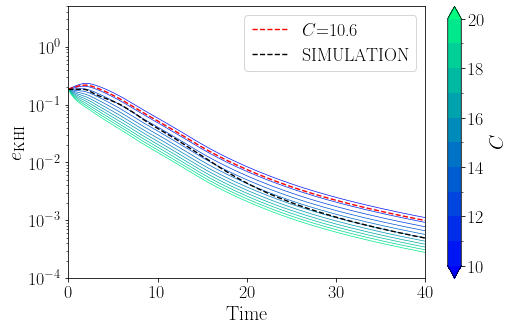

In [11]:
factor_c = np.linspace(10,20,11)
factor_gamma = np.linspace(0.1,0.25,20)

bx0 = '3e-4'

res = 'res_512_512_512/CVP--bx'+bx0+'--512--rndom/stress_tensors_global/'
#res ='res_128_128_128/CVP--bx3e-4--128--rndom/stress_tensors_global'
#res3 ='res_256_256_256/CVP--bx3e-2--256--rndom/stress_tensors_global'
tfinal = 40
lent = 201
t = np.linspace(0,tfinal,lent)


dv_tot = np.loadtxt('KHI/growth_rates/av_growth--bx'+bx0+'--512--v2.dat', usecols=1)
gamma_khi0 = dv_tot
    
Msim,Rsim,Fsim,rho = stresses_r0(res,t)
energy_tracerndm =0.5*rho[0]*(Rsim[:,0]+Rsim[:,3]+Rsim[:,5])
energy_ini = energy_tracerndm[0]*1e-0

#================================================
v0 = 0.5
al = 0.01
filtersize = 100000000
scale = 15.8*0.25
#=================================================

color = sns.color_palette('winter',len(factor_gamma))
cmap =matplotlib.cm.winter

new_c = np.array([6,8,10,12])

fig, ax = plt.subplots(figsize = (8,5))
color = sns.color_palette('winter',len(factor_c))
#new_gamma = np.array([3,5,7,10])
new_gamma = 0.14

ax.tick_params(axis='x',labelsize = 18)
ax.tick_params(axis='y',labelsize = 18)

gamma_khi = gamma_khi0*new_gamma

for k in range(0,len(factor_c)):

    energy_trndm = energy_ev(scale,t, factor_c[k],energy_ini,gamma_khi,rho[0])

    ax.plot(t[:], energy_trndm[:],linewidth = .7, linestyle = 'solid', color = color[k])

energy_trndm = energy_ev(scale,t, 10.6,energy_ini,gamma_khi,rho[0])
ax.plot(t[:], energy_trndm[:],linewidth = 1.4, linestyle = 'dashed', color = 'r',label=r'$C$=10.6')
ax.plot(t[:], energy_tracerndm[:], linewidth = 1.4, linestyle = 'dashed', color = 'k', label = 'SIMULATION')

ax.set_yscale('log')
ax.set_ylim([1e-4,5])
ax.set_xlim([0,40])
ax.set_xlabel('Time', fontsize = '20')
ax.legend(loc = 'upper right', ncol = 1, frameon = 'True', fontsize = '18')

ax.set_ylabel(r'$e_{\rm KHI}$', fontsize = '20')
# fig.suptitle(r'$B_{x0}=$'+bx0, fontsize = '30')
norm = matplotlib.colors.BoundaryNorm(factor_c, cmap.N, extend='both')
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, orientation='vertical')
cb.set_label(r'$C$', size = '20')
cb.ax.tick_params(labelsize='18')
#    plt.show()
#fig.savefig('KHI/playing/gnew--512--bx'+bx0+'--var_fac-c--bis.pdf',bbox_inches = 'tight')
#    plt.close()

In [12]:
fig, ax = plt.subplots(1,4,sharex = 'all', sharey = 'row', figsize = (28,5))
color = sns.color_palette('winter',len(factor_c))
new_gamma = np.array([0.1,0.14,0.17,0.2])
for i in range(0,len(new_gamma)):
    ax[i].tick_params(axis='x',labelsize = 18)
    ax[i].tick_params(axis='y',labelsize = 18)
 
    gamma_khi = gamma_khi0*new_gamma[i]
 
    for k in range(0,len(factor_c)):
 
        energy_trndm = energy_ev(scale,t, factor_c[k],energy_ini,gamma_khi,rho[0])

        ax[i].plot(t[:], energy_trndm[:],linewidth = .9, linestyle = 'solid', color = color[k])

    energy_trndm = energy_ev(scale,t, 10.6,energy_ini,gamma_khi,rho[0])
    ax[i].plot(t[:], energy_trndm[:],linewidth = .9, linestyle = 'dashed', color = 'r',label=r'$C$=10.6')
    ax[i].plot(t[:], energy_tracerndm[:], linewidth = 1.2, linestyle = 'dashed', color = 'k', label = 'SIMULATION')
    ax[i].set_title(r'$A_{\gamma}=$ '+str(new_gamma[i]), fontsize = '24')
    ax[i].set_yscale('log')
    ax[i].set_ylim([1e-4,5])
    ax[i].set_xlim([0,40])
    ax[i].set_xlabel('Time', fontsize = '20')
    ax[i].legend(loc = 'upper right', ncol = 1, frameon = 'True', fontsize = '18')

ax[0].set_ylabel(r'$e_{\rm KHI}$', fontsize = '20')
norm = matplotlib.colors.BoundaryNorm(factor_c, cmap.N, extend='both')
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, orientation='vertical')
cb.set_label(r'$C$', size = '20')
cb.ax.tick_params(labelsize='18')
